# Market Making with Alpha Signals

## H
$\Upsilon = \Delta + \epsilon$ where $\Delta$ is the market spread and $\epsilon \gt 0$ represents the exchange fee.

Problem:

...

Development of solution:

Terminal condition:

$H(T,x,S,\alpha,q)=x+q(S-sign(q)\Upsilon-\psi q)$

Solution:



$H(t,x,S,\alpha,q)=x+qS+\hat{h}(t,\alpha, q)$

with terminal condition:

$\hat{h}(T,\alpha, q)=q(-sign(q)\Upsilon-\psi q)$

$\psi$ is a constant and $\psi Q_t$ represents the extra cost of walking the LOB at the end of the session.


### Parameters

In [1]:
from types import SimpleNamespace
simulation_parameters = {
    'q_max': 4,
    'T': 60,
    'A': 300,
    'dalpha': 30,
    'Delta': 0.005,
    'epsilon': 0.005,
    'psi': 0.01,
    'phi_': 1e-6,
    'eta': 60.0,
    'sigma': 0.01,
    'k': 200.0,
    'xi': 1.0,
    'lambda_plus': 1.0,
    'lambda_minus': 1.0,
    'theta': 0.1,
    's0': 100,
    'n': 10
}
p = SimpleNamespace(**simulation_parameters)
p.dt = (p.k * p.A / p.dalpha + p.lambda_plus + p.lambda_minus)**(-1)

### Definitions

In [25]:
import numpy as np

# class H(SimpleNamespace): TODO: Transform H into a class that will generate H
#     def __init__(self, p)
q_max, T, A, dalpha, Delta, epsilon, psi, phi_, eta, sigma, k, xi, lambda_plus, lambda_minus = p.q_max, p.T, p.A, p.dalpha, p.Delta, p.epsilon, p.psi, p.phi_, p.eta, p.sigma, p.k, p.xi, p.lambda_plus, p.lambda_minus

Upsilon = Delta + epsilon

dt = (k * A / dalpha + lambda_plus + lambda_minus)**(-1)

q_a = np.arange(-q_max, q_max + 1, 1)
alpha = np.arange(-A, A + 1, dalpha)

alpha_smaller_0 = np.where(alpha < 0)[0]
alpha_greater_0 = np.where(alpha > 0)[0]
alpha_0 = np.where(alpha == 0)[0]   

n_q = len(q_a)
n_alpha = len(alpha)
n_t = int(T / dt)

h = np.full((n_t, n_alpha, n_q), np.nan)
d_alpha_h = np.zeros(n_alpha)
dd_alpha_h = np.zeros(n_alpha)

l_plus = np.zeros((n_t, n_alpha, n_q))
l_minus = np.zeros((n_t, n_alpha, n_q))

h_eta_up = np.full((n_t, n_alpha, n_q), np.nan)
h_eta_down = np.full((n_t, n_alpha, n_q), np.nan)


def T_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h):
    h_t_1_q = h[t_i + 1, :, q_i]
    q_ = q_a[q_i]

    l_plus_term = get_l_plus_term(t_i, q_i, h_t_1_q)

    l_minus_term = get_l_minus_term(t_i, q_i, h_t_1_q)

    h_t_q = h_t_1_q + dt * (
        alpha * sigma * q_
        - k * alpha * d_alpha_h
        + ((xi**2) / 2) * dd_alpha_h
        - phi_ * q_**2
        + l_plus_term
        + l_minus_term
    )

    # impose second derivative vanishes along maximum and minimum values of alpha grid
    h_t_q[0] = 2 * h_t_q[1] - h_t_q[2]
    h_t_q[-1] = 2 * h_t_q[-2] - h_t_q[-3]
    return h_t_q


def get_l_minus_term(t_i, q_i, h_t_1_q):
    if q_a[q_i] < q_max:
        l_minus_term = lambda_minus * np.maximum(
            (Delta + h_eta_down[t_i + 1, :, q_i + 1] - h_t_1_q),
            (h_eta_down[t_i + 1, :, q_i] - h_t_1_q),
        )
    else:
        l_minus_term = h_eta_down[t_i + 1, :, q_i] - h_t_1_q
    return l_minus_term


def get_l_plus_term(t_i, q_i, h_t_1_q):
    if q_a[q_i] > -q_max:
        l_plus_term = lambda_plus * np.maximum(
            (Delta + h_eta_up[t_i + 1, :, q_i - 1] - h_t_1_q),
            (h_eta_up[t_i + 1, :, q_i] - h_t_1_q),
        )
    else:
        l_plus_term = h_eta_up[t_i + 1, :, q_i] - h_t_1_q
    return l_plus_term


def M_dt_dalpha(h, t_i, q_i):
    if q_a[q_i] < q_max and q_a[q_i] > -q_max:
        return np.maximum(
            (h[t_i + 1, :, q_i - 1] - Upsilon), (h[t_i + 1, :, q_i + 1] - Upsilon)
        )
    elif q_a[q_i] > -q_max:
        return h[t_i + 1, :, q_i - 1] - Upsilon
    elif q_a[q_i] < q_max:
        return h[t_i + 1, :, q_i + 1] - Upsilon
    else:
        raise ValueError(f"Imposible Case {q_a[q_i]}")


def S_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h):
    T_dt_dalpha_i = T_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h)
    M_dt_dalpha_i = M_dt_dalpha(h, t_i, q_i)
    return np.maximum(T_dt_dalpha_i, M_dt_dalpha_i)


def calculate_d_alpha_h(h_q_t):
    d_alpha_h[alpha_smaller_0] = (
        h_q_t[alpha_smaller_0 + 1] - h_q_t[alpha_smaller_0]
    ) / dalpha
    d_alpha_h[alpha_greater_0] = (
        h_q_t[alpha_greater_0] - h_q_t[alpha_greater_0 - 1]
    ) / dalpha
    d_alpha_h[alpha_0] = (
        (h_q_t[alpha_0 + 1] - h_q_t[alpha_0]) +
        (h_q_t[alpha_0] - h_q_t[alpha_0 - 1])
    ) / (2 * dalpha)
    return d_alpha_h


def calculate_dd_alpha_h(h_q_t):
    dd_alpha_h[1:-1] = (h_q_t[2:] - 2 * h_q_t[1:-1] - h_q_t[:-2]) / (dalpha**2)
    return dd_alpha_h


def extrapolate_up(phi, n, diff):
    delta_phi = phi[-1] - phi[-2]
    phi_extrapolated = (
        np.ones(n) * phi[-1] + diff * delta_phi + np.arange(0, n) * delta_phi
    )
    return phi_extrapolated


def interpolate(phi, up=True):
    eta_dalpha = eta / dalpha
    eta_dalpha_floor = np.floor(eta_dalpha)
    eta_dalpha_diff = eta_dalpha - eta_dalpha_floor
    eta_move = int(eta_dalpha_floor)

    phi_eta = phi if up else np.flip(phi)

    phi_eta = np.roll(phi_eta, -eta_move)
    phi_eta[-eta_move:] = np.nan

    phi_eta_1 = np.roll(phi_eta, -1)
    phi_eta_1[-1:] = np.nan

    phi_eta += (phi_eta_1 - phi_eta) * eta_dalpha_diff
    phi_eta[-eta_move - 1:] = extrapolate_up(
        phi if up else np.flip(phi), len(
            phi_eta[-eta_move - 1:]), eta_dalpha_diff
    )

    phi_eta = phi_eta if up else np.flip(phi_eta)

    return phi_eta


def find_optimal_postings(h, t_i, q_i):
    h_eta_up[t_i + 1, :, q_i] = interpolate(h[t_i + 1, :, q_i])
    if q_a[q_i] > -q_max:
        h_eta_up[t_i + 1, :, q_i - 1] = interpolate(h[t_i + 1, :, q_i - 1])
        l_plus_i = np.where(
            Delta + h_eta_up[t_i + 1, :, q_i -
                             1] > h_eta_up[t_i + 1, :, q_i], 1, 0
        )
    else:
        l_plus_i = np.zeros(n_alpha)

    h_eta_down[t_i + 1, :, q_i] = interpolate(h[t_i + 1, :, q_i], up=False)
    if q_a[q_i] < q_max:
        h_eta_down[t_i + 1, :, q_i +
                   1] = interpolate(h[t_i + 1, :, q_i + 1], up=False)
        l_minus_i = np.where(
            Delta + h_eta_down[t_i + 1, :, q_i +
                               1] > h_eta_down[t_i + 1, :, q_i], 1, 0
        )
    else:
        l_minus_i = np.zeros(n_alpha)
    return l_plus_i, l_minus_i


### Calculate H (takes long)

In [26]:
# Terminal and boundary conditions
h[-1, :, :] = (
    np.ones((1, n_alpha)) *
    np.array([(q_a * (-np.sign(q_a) * Upsilon - psi * q_a))]).T
).T

for t_i in range(n_t - 2, -1, -1):
    for q_i in range(n_q):
        h_q_t_1 = h[t_i + 1, :, q_i]
        d_alpha_h = calculate_d_alpha_h(h_q_t_1)
        dd_alpha_h = calculate_dd_alpha_h(h_q_t_1)
        l_plus[t_i + 1, :, q_i], l_minus[t_i + 1, :, q_i] = find_optimal_postings(
            h, t_i, q_i
        )
        h[t_i, :, q_i] = S_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h)

c:\1_Projects\Tesis Quant UdeSA\optimal-market-making-main\.venv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  import sys


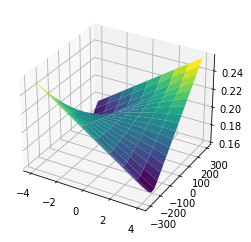

In [31]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
  
x, y = np.meshgrid(q_a, alpha)

fig = plt.figure()
axes = fig.gca(projection ='3d')
axes.plot_surface(x, y, h[0,:,:], cmap='viridis')

plt.show()

In [2]:
np.save("h.npy",h)
np.save("q.npy",q_a)
np.save("alpha.npy", alpha)
np.save("l_plus.npy", l_plus)
np.save("l_minus.npy", l_minus)

NameError: name 'q_a' is not defined

### Obtain optimal MO postings (takes long)

In [2]:
import numpy as np
h = np.load("h.npy")
q_a = np.load("q.npy")
alpha = np.load("alpha.npy")
l_plus = np.load("l_plus.npy")
l_minus = np.load("l_minus.npy")

In [3]:
def find_optimal_MO(h, t_i, q_i):
    # if q_a[q_i] <= q_max and q_a[q_i] >= -q_max:
    #     postings = np.where(M_dt_dalpha(h, t_i, q_i) > h[t_i, :, q_i], 1, 0)
    # else:
    #     postings = np.zeros(n_alpha)
    
    # if q_a[q_i] > 0:
    #     mo_minus_i = postings
    #     mo_plus_i = np.zeros(n_alpha)
    # elif q_a[q_i] < 0:
    #     mo_minus_i = np.zeros(n_alpha)
    #     mo_plus_i = postings
    # else:
    #     mo_minus_i = np.zeros(n_alpha)
    #     mo_plus_i = np.zeros(n_alpha)

    if q_a[q_i] > -(q_max - 1):
        # h_eta_down_q_m_1 = interpolate(h[t_i + 1, :, q_i - 1], up=False)
        # mo_minus_i = np.where(- Upsilon + h_eta_down_q_m_1 > h[t_i + 1, :, q_i], 1, 0)
        mo_minus_i = np.where((h[t_i + 1, :, q_i - 1] - Upsilon) > h[t_i + 1, :, q_i], 1, 0)
    else:
        mo_minus_i = np.zeros(n_alpha)

    if q_a[q_i] < (q_max - 1):
        # h_eta_up_q_p_1 = interpolate(h[t_i + 1, :, q_i + 1])
        # mo_plus_i = np.where(- Upsilon + h_eta_up_q_p_1 > h[t_i + 1, :, q_i], 1, 0)
        mo_plus_i = np.where((h[t_i + 1, :, q_i + 1] - Upsilon) > h[t_i + 1, :, q_i],1,0)
    else:
        mo_plus_i = np.zeros(n_alpha)


    return mo_plus_i, mo_minus_i

In [33]:
mo_plus = np.zeros((n_t, n_alpha, n_q))
mo_minus = np.zeros((n_t, n_alpha, n_q))

for t_i in range(n_t - 2, -1, -1):
    for q_i in range(n_q):
        mo_plus[t_i + 1, :, q_i], mo_minus[t_i + 1, :, q_i] = find_optimal_MO(
            h, t_i, q_i
        )

In [257]:
np.save("mo_plus.npy", mo_plus)
np.save("mo_minus.npy", mo_minus)

## Pure Jump Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In this case the poisson arrivals are created by simulating the entire T time and ordering those uniformly. This simulation is interpreting the Poisson process as a distribution of point counts. In this way time between arrivals have an exponential probability distribution.

117
[0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1
 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1
 0 1 1 0 0 1]
[-1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1
 -1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1 -1  1  1 -1 -1 -1
 -1  1  1 -1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1 -1
 -1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1  1 -1 -1 -1
  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]


(array([47., 28., 17.,  7.,  6.,  2.,  4.,  0.,  1.,  4.]),
 array([1.34368354e-03, 2.51790198e-01, 5.02236712e-01, 7.52683226e-01,
        1.00312974e+00, 1.25357625e+00, 1.50402277e+00, 1.75446928e+00,
        2.00491580e+00, 2.25536231e+00, 2.50580882e+00]),
 <BarContainer object of 10 artists>)

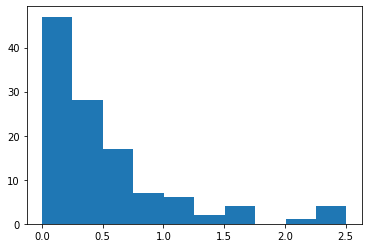

In [2]:
T=60
np.random.seed(1)
lambda_ = (1., 1.)
sigma = 1
number_of_market_orders=np.random.poisson(sum(lambda_) * T)
print(number_of_market_orders)
times = np.sort(np.random.uniform(size=number_of_market_orders)*T)
#print(times)
markers = np.random.binomial(n=1, p=lambda_[1] / sum(lambda_), size=number_of_market_orders)
jumps = np.where(markers == 0, -1, 1)
print(markers)
print(jumps)
s = sigma * np.cumsum(jumps)
plt.hist(np.diff(times))


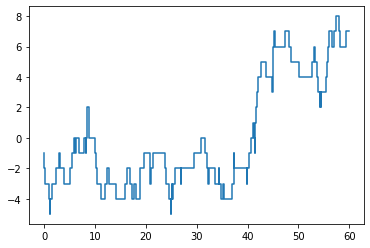

In [3]:
plt.step(times, s)

## Other way of simulating poisson arrivals

On the other hand, generating a random uniform variable for each dt will also generate a possion distribution if at each time we analyze the exponential probability distribution required. We are interpreting the poisson process as a counting process.

Thus, as for a Poisson process

$P(N_t - N_0 = n ) = \frac{(\lambda t)^n}{n!}e^{-\lambda t}$

Considering the probability of more than one arrival in dt negligible then

$P(N_t-N_{t-1}=n \neq 0)= \sum_{i=1}^{\infty} \frac{(\lambda dt)^i}{i!}e^{-\lambda dt}$

$P(N_t-N_{t-1}=n \neq 0)= 1-e^{-\lambda dt}$

which is the exponential distribution, as expected for the time of arrivales of a Poisson Process

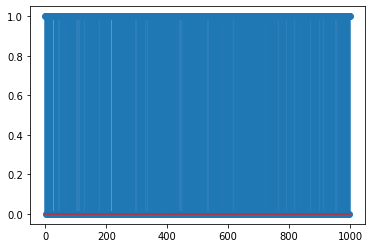

(array([381.,   0., 177.,   0.,  48.,   0.,  14.,   0.,   9.,   3.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

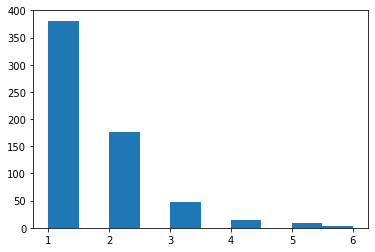

In [4]:
l = 1
n=1000
dt=1
arrivals = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (l))), decimals=4),1,0)
plt.stem(arrivals)
plt.show()

t=np.array(range(n))
arrival_times = arrivals*t
arrival_times = arrival_times[arrival_times != 0]
arrival_times
distribution = np.diff(arrival_times)
plt.hist(distribution)

## Simulation of paths
dAlpha and dS as of Market Making with Alpha Signals

### Experimenting

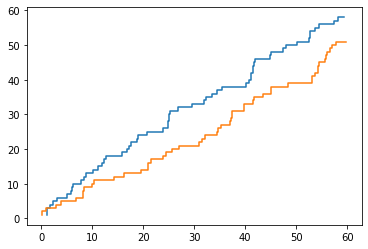

In [5]:
T=60
np.random.seed(1)
lambda_ = (1., 1.)
number_of_market_orders_buy=np.random.poisson(lambda_[0] * T)
number_of_market_orders_sell=np.random.poisson(lambda_[1] * T)
tau_plus = np.sort(np.random.uniform(size=number_of_market_orders_buy)*T)
tau_minus = np.sort(np.random.uniform(size=number_of_market_orders_sell)*T)
dMt_plus = np.ones(number_of_market_orders_buy)
dMt_minus = np.ones(number_of_market_orders_sell)
Mt_plus = dMt_plus.cumsum()
Mt_minus = dMt_minus.cumsum()
plt.step(tau_plus, Mt_plus)
plt.step(tau_minus, Mt_minus)


As in Jaimungal we can iterate in t but simulate across using an n size vector, generating n simulations at once.

Also since $d \alpha_t = -k \alpha_t dt$ then, $\alpha_t = c * e^{-k t}$

Alpha thus have a mean reverting component. 

I don't get why Jaimungal solves it using $\alpha_t = e^{-\zeta * dt} * \alpha_{t-1} $ since in the page 220 of AHFT solution is $\alpha_t = \alpha_0 e^{-k t}$

I guess since $\alpha_t = \alpha_0 e^{-k t}$, 

then

$\alpha_{t + dt} = \alpha_0 e^{-k (t+dt)}$

$\alpha_{t + dt} = \alpha_0 e^{-kt-k*dt}$

$\alpha_{t + dt} = \alpha_0 e^{-kt}e^{-k*dt}$

$\alpha_{t + dt} = \alpha_t e^{-k*dt}$

Condition as in paper:

$d\alpha_t=-k\alpha_t dt + \xi dW_t + \eta^+ (dM_t^{0+}+dM_t^+)-\eta^-(dMt_t^{0-}+dM_t^-), \alpha_0=0$


### Generate simulations

In [4]:
import numpy as np
h = np.load("h.npy")
q = np.load("q.npy")
alpha = np.load("alpha.npy")
l_plus = np.load("l_plus.npy")
l_minus = np.load("l_minus.npy")
mo_plus = np.load("mo_plus.npy")
mo_minus = np.load("mo_minus.npy")

MO_p: 0.0
MO_m: 1.0
LO_p: 56.0
LO_m: 55.0
Mean of PNL:0.2899999999998862
Stde of PNL:0.15172343260031332
Mean of X:0.0
Stde of X:0.0


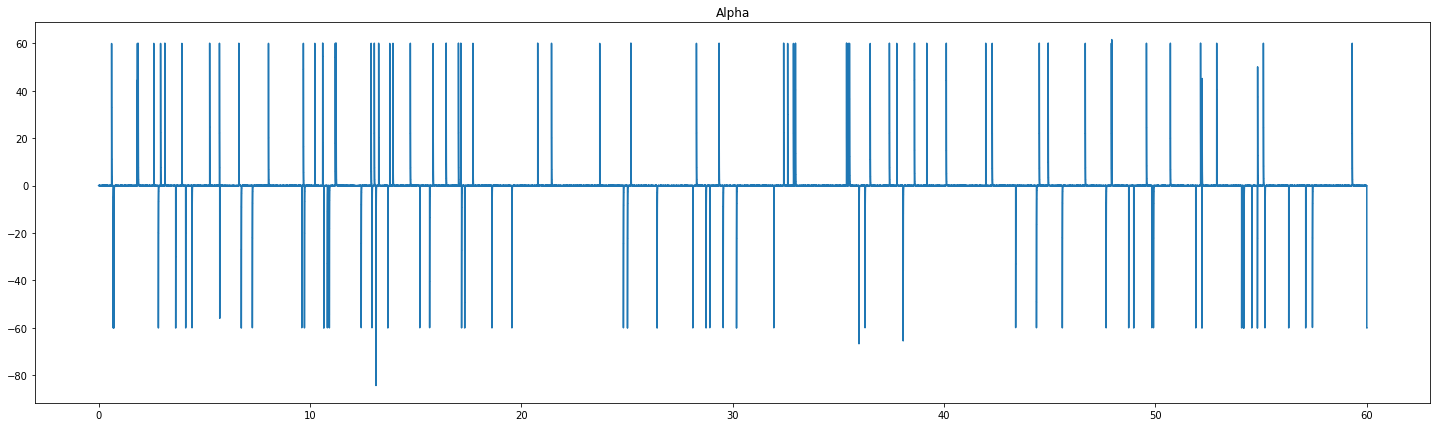

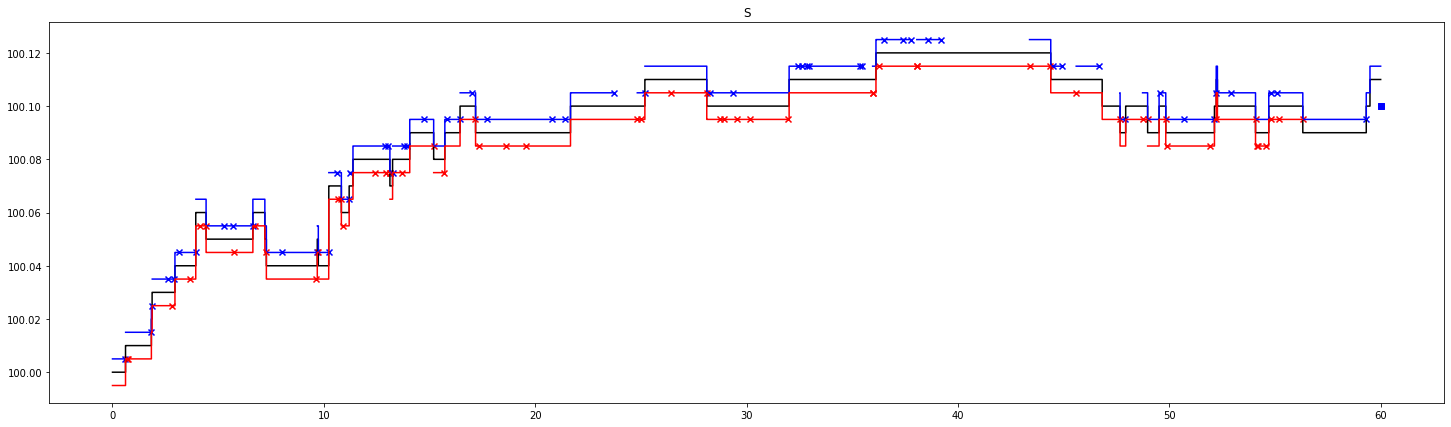

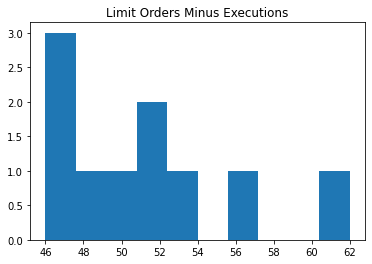

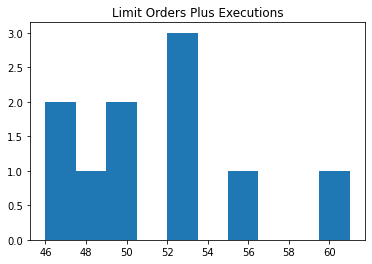

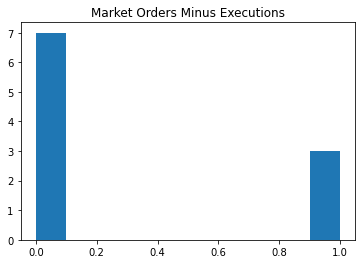

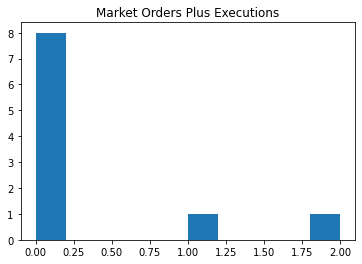

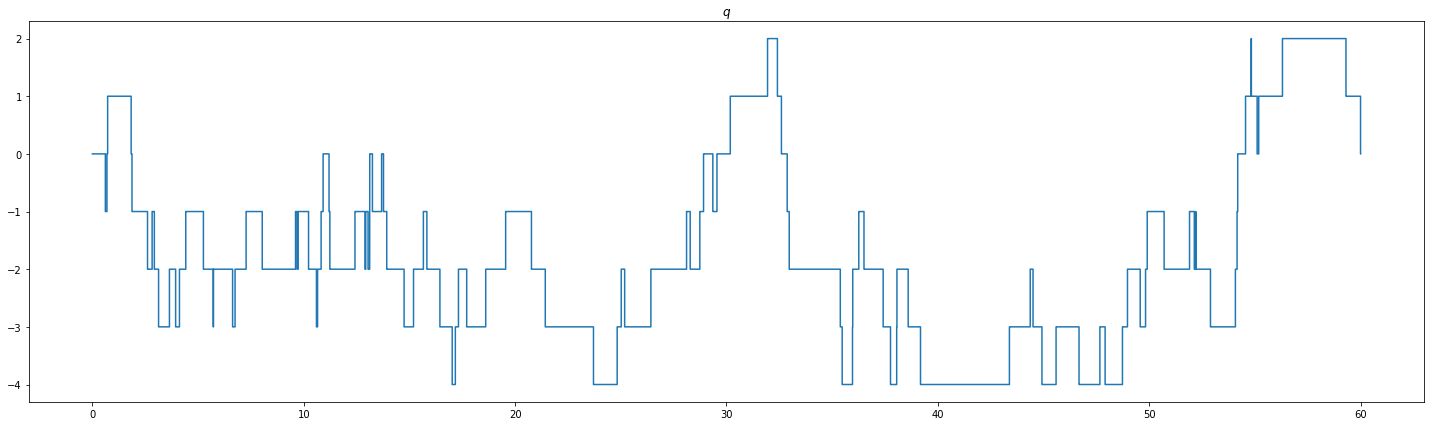

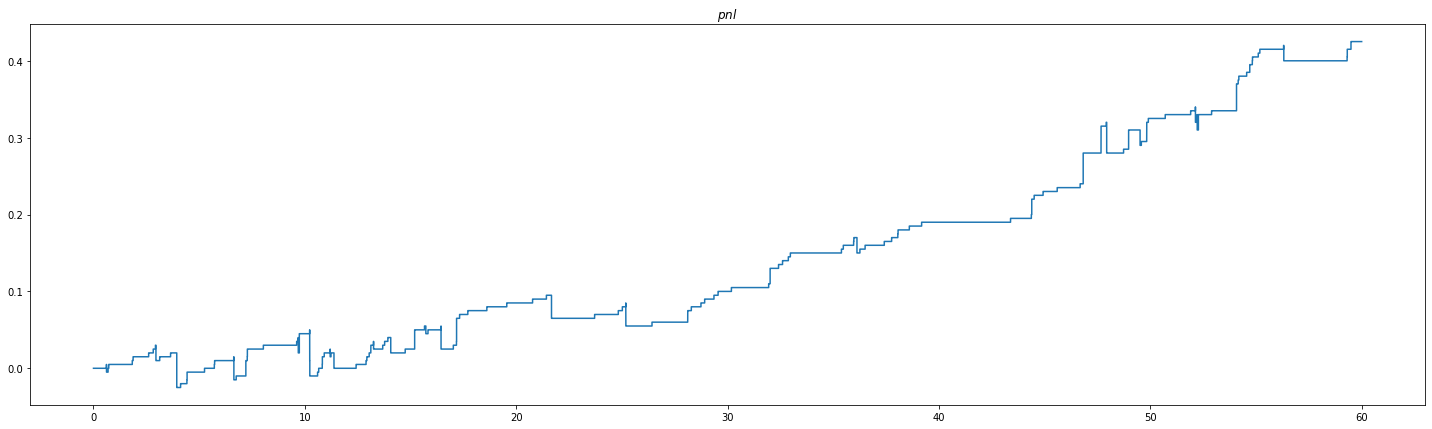

In [5]:
# TODO: Create class Simulator or similar
from matplotlib import pyplot as plt

np.random.seed(1)
dMt_minus = 0
dMt_plus = 0


def generate_simulations(p, h, l_p, l_m, mo_p, mo_m, plot=False):
    n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, xi, sigma, theta, s0, A, dalpha, q_max, Delta, epsilon = p.n, p.k, p.eta, p.eta, p.lambda_plus, p.lambda_minus, p.T, p.xi, p.sigma, p.theta, p.s0, p.A, p.dalpha, p.q_max, p.Delta, p.epsilon

    Upsilon = Delta + epsilon

    dt = (k * A / dalpha + lambda_plus + lambda_minus)**(-1)
    
    m = int(T/dt)
    
    # Alpha setup
    alpha = np.full((n, m), np.nan)
    alpha[:, 0] = 0
    alpha_range = np.arange(-A, A + 1, dalpha)

    tau_plus_amounts = np.random.poisson(lambda_plus*T, n)
    tau_minus_amounts = np.random.poisson(lambda_minus*T, n)
    tau_plus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_plus_amounts]
    tau_minus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_minus_amounts]

    dMt0_plus = np.array([np.histogram(tau_i,np.linspace(0,T,m+1))[0] for tau_i in tau_plus])
    dMt0_minus = np.array([np.histogram(tau_i,np.linspace(0,T,m+1))[0] for tau_i in tau_minus])

    # S setup
    s = np.full((n, m), np.nan)
    s[:, 0] = s0

    mu_plus = np.full((n, m), np.nan)
    mu_plus[:, 0] = theta
    mu_minus = np.full((n, m), np.nan)
    mu_minus[:, 0] = theta

    dJ_plus = np.full((n, m), np.nan)
    dJ_plus[:, 0] = 0

    dJ_minus = np.full((n, m), np.nan)
    dJ_minus[:, 0] = 0

    # Positions setup
    l_p_position = np.full((n, m), np.nan)
    l_m_position = np.full((n, m), np.nan)

    p_postings = np.full((n, m), np.nan)
    m_postings = np.full((n, m), np.nan)

    p_executions = np.full((n, m), np.nan)
    m_executions = np.full((n, m), np.nan)

    p_executions_count = np.full((n, m), np.nan)
    m_executions_count = np.full((n, m), np.nan)

    mo_p_executions = np.full((n, m), np.nan)
    mo_m_executions = np.full((n, m), np.nan)

    dMt_plus = np.full((n, m), np.nan) # np.zeros((n, m))
    dMt_minus = np.full((n, m), np.nan) # np.zeros((n, m))

    pnl = np.full((n, m), np.nan)
    pnl[:, 0] = 0

    X = np.full((n, m), np.nan)
    X[:, 0] = 0

    def get_closest_index(val):
        return int(np.round(min(max(-p.A,val),p.A) / p.dalpha, 0)) + int(p.A / p.dalpha)

    def get_l_p(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return l_p[t_i, alpha_i, q_i]
    get_l_p_v = np.vectorize(get_l_p)

    def get_l_m(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return l_m[t_i, alpha_i, q_i]
    get_l_m_v = np.vectorize(get_l_m)

    def get_MM_MO_p(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return mo_p[t_i, alpha_i, q_i]
    get_MM_MO_p_v = np.vectorize(get_MM_MO_p)
    
    def get_MM_MO_m(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return mo_m[t_i, alpha_i, q_i]
    get_MM_MO_m_v = np.vectorize(get_MM_MO_m)

    # Inventory setup
    q = np.full((n, m), np.nan)
    q[:, 0] = 0

    # Simulations
    for i in range(m-1):
        #dMt_minus and dMt_plus depend on the MM
        dMt_plus[:, i] = get_MM_MO_p_v(i, alpha[:, i], q[:, i])
        dMt_minus[:, i] = get_MM_MO_m_v(i, alpha[:, i], q[:, i])

        l_p_position[:, i] = get_l_p_v(i, alpha[:, i], q[:, i])
        l_m_position[:, i] = get_l_m_v(i, alpha[:, i], q[:, i])

        alpha[:, i+1] = alpha[:,i] * np.exp(-k * dt) + xi * np.sqrt(dt) * (np.random.randn(n)) + eta_plus *(dMt0_plus[:,i] + dMt_plus[:, i]) - eta_minus * (dMt0_minus[:,i] + dMt_minus[:, i])

        mu_plus[:, i+1] = np.where(alpha[:, i+1]>0, alpha[:, i+1],0) + theta
        mu_minus[:, i+1] = np.where(alpha[:, i+1]<0, -alpha[:, i+1],0) + theta

        dJ_plus[:, i+1] = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (mu_plus[:,i+1]))), decimals=4),1,0)
        dJ_minus[:, i+1] = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (mu_minus[:,i+1]))), decimals=4),1,0)
        
        s[:,i+1] = s[:,i] + sigma * (dJ_plus[:, i+1] - dJ_minus[:, i+1])

        q[:, i+1] = q[:, i] - np.where(l_p_position[:, i] * dMt0_plus[:, i] > 0,1,0) + np.where((l_m_position[:, i] * dMt0_minus[:, i]) > 0,1,0) - np.where(dMt_minus[:, i] > 0,1,0) + np.where(dMt_plus[:,i] > 0,1,0)

        p_postings[:, i] = np.where(l_p_position[:,i]==0, np.nan, (s[:,i]+Delta)*l_p_position[:,i])
        p_executions_count[:,i] = np.where(l_p_position[:,i]*dMt0_plus[:,i]==0, 0, 1)
        p_executions[:, i] = np.where(l_p_position[:,i]*dMt0_plus[:,i]==0, np.nan, (s[:,i]+Delta)*l_p_position[:,i]*np.where(dMt0_plus[:,i]>0,1,0))
        
        m_postings[:,i] = np.where(l_m_position[:,i]==0, np.nan, (s[:,i]-Delta)*l_m_position[:,i])
        m_executions_count[:,i] = np.where(l_m_position[:,i]*dMt0_minus[:,i]==0, 0, 1)
        m_executions[:,i] = np.where(l_m_position[:,i]*dMt0_minus[:,i]==0, np.nan, (s[:,i]-Delta)*l_m_position[:,i]*np.where(dMt0_minus[:,i]>0,1,0))

        mo_p_executions[:,i] = np.where(dMt_plus[:, i]==0, np.nan, (s[:,i]+Upsilon)*dMt_plus[:, i])
        mo_m_executions[:,i] = np.where(dMt_minus[:, i]==0, np.nan, (s[:,i]-Upsilon)*dMt_minus[:, i])

        X[:,i+1] = X[:,i] + np.where(p_executions[:,i+1] > 0, s[:, i+1] + Delta, 0) - np.where(m_executions[:,i+1] > 0, s[:, i+1]-Delta, 0)\
            - np.where(mo_p_executions[:,i+1] > 0, s[:, i+1] + Upsilon, 0) \
            + np.where(mo_m_executions[:,i+1] > 0, s[:, i+1] - Upsilon, 0)

        pnl[:,i+1] = pnl[:,i] + np.where(p_executions[:,i] > 0, Delta, 0) + np.where(m_executions[:,i] > 0, Delta, 0)\
            + q[:, i] * (s[:, i+1] - s[:, i]) \
            - np.where(mo_p_executions[:,i+1] > 0, Upsilon, 0) \
            - np.where(mo_m_executions[:,i+1] > 0, Upsilon, 0)
        
    X[:,-1] = X[:,-1] - q[:, -1] * (s[:, -1]) - np.abs(q[:,-1])*Upsilon
    # pnl[:,-1] = pnl[:,-1] - Upsilon * np.abs(q[:,-1])

    if plot:
        plt_i = 1
        plt.figure(figsize=(25,7))
        plt.title('Alpha')
        plt.step(np.linspace(0,T,m),alpha[plt_i])

        plt.figure(figsize=(25,7))
        plt.title('S')
        plt.step(np.linspace(0,T,m), s[plt_i], c='black')
        
        plt.step(np.linspace(0,T,m), p_postings[plt_i], c='b')
        plt.scatter(np.linspace(0,T,m), p_executions[plt_i], marker='x', c='b')

        plt.step(np.linspace(0,T,m), m_postings[plt_i], c='r')
        plt.scatter(np.linspace(0,T,m), m_executions[plt_i], marker='x', c='r')

        plt.scatter(np.linspace(0,T,m), mo_m_executions[plt_i], marker='s', c='b')
        plt.scatter(np.linspace(0,T,m), mo_p_executions[plt_i], marker='s', c='r')
        print(f"MO_p: {np.nansum(dMt_plus[plt_i])}")
        print(f"MO_m: {np.nansum(dMt_minus[plt_i])}")
        print(f"LO_p: {np.nansum(m_executions_count[plt_i])}")
        print(f"LO_m: {np.nansum(p_executions_count[plt_i])}")
        print(f"Mean of PNL:{np.average(pnl[:,-1])}")
        print(f"Stde of PNL:{np.std(pnl[:,-1])}")
        print(f"Mean of X:{np.average(X[:,-1])}")
        print(f"Stde of X:{np.std(X[:,-1])}")

        plt.figure()
        plt.title('Limit Orders Minus Executions')
        plt.hist(m_executions_count[:,:-1].sum(axis=1))
        
        plt.figure()
        plt.title('Limit Orders Plus Executions')
        plt.hist(p_executions_count[:,:-1].sum(axis=1))

        plt.figure()
        plt.title('Market Orders Minus Executions')
        plt.hist(dMt_minus[:, :-1].sum(axis=1))
        
        plt.figure()
        plt.title('Market Orders Plus Executions')
        plt.hist(dMt_plus[:, :-1].sum(axis=1))

        if False:
            plt.figure()
            plt.title('$\mu_+$')
            plt.step(np.linspace(0,T,m),mu_plus[plt_i])

            plt.figure()
            plt.title('$\mu_-$')
            plt.step(np.linspace(0,T,m),mu_minus[plt_i])
        
        plt.figure(figsize=(25,7))
        plt.title('$q$')
        plt.step(np.linspace(0,T,m),q[plt_i])

        plt.figure(figsize=(25,7))
        plt.title('$pnl$')
        plt.step(np.linspace(0,T,m),pnl[plt_i])
        
        
    return alpha, mu_plus, mu_minus, dJ_plus, dJ_minus, s, l_p_position, l_m_position, q, dMt0_plus, dMt0_minus, pnl, dMt_plus, dMt_minus,p_executions_count, m_executions_count, pnl, X
# _ = generate_simulations(n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, dt, xi, sigma, theta, s0, plot=True)
np.random.seed(2)
# example_params = SimpleNamespace(n=1, k=1, eta_plus=1, eta_minus=1, lambda_plus=1, lambda_minus=1, T=50, dt=0.01, xi=1, sigma=0.1, theta=1, s0=10)
alpha, mu_plus, mu_minus, dJ_plus, dJ_minus, s, l_p_position, l_m_position, q, dMt0_plus, dMt0_minus, pnl, dMt_plus, dMt_minus, p_executions_count, m_executions_count, pnl, X = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=True)

In [58]:
np.average(pnl[:,-1])

0.2619999999998719

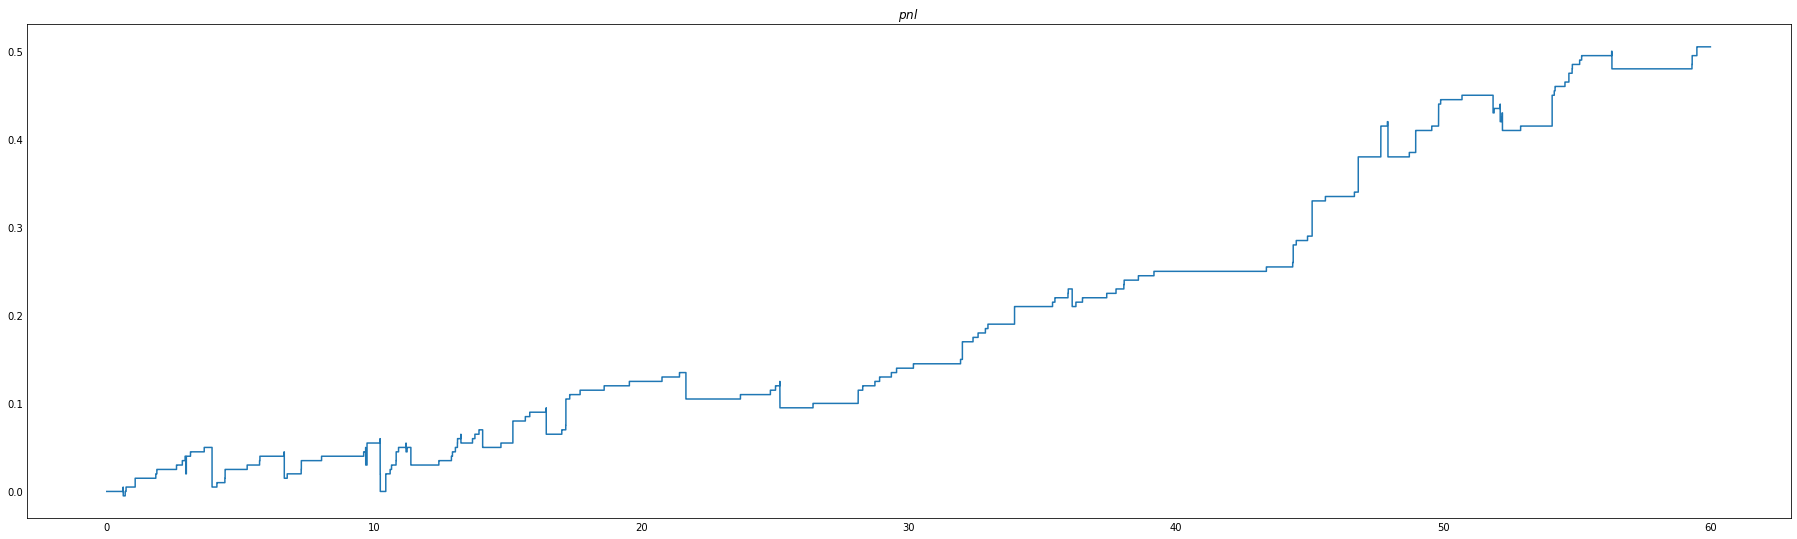

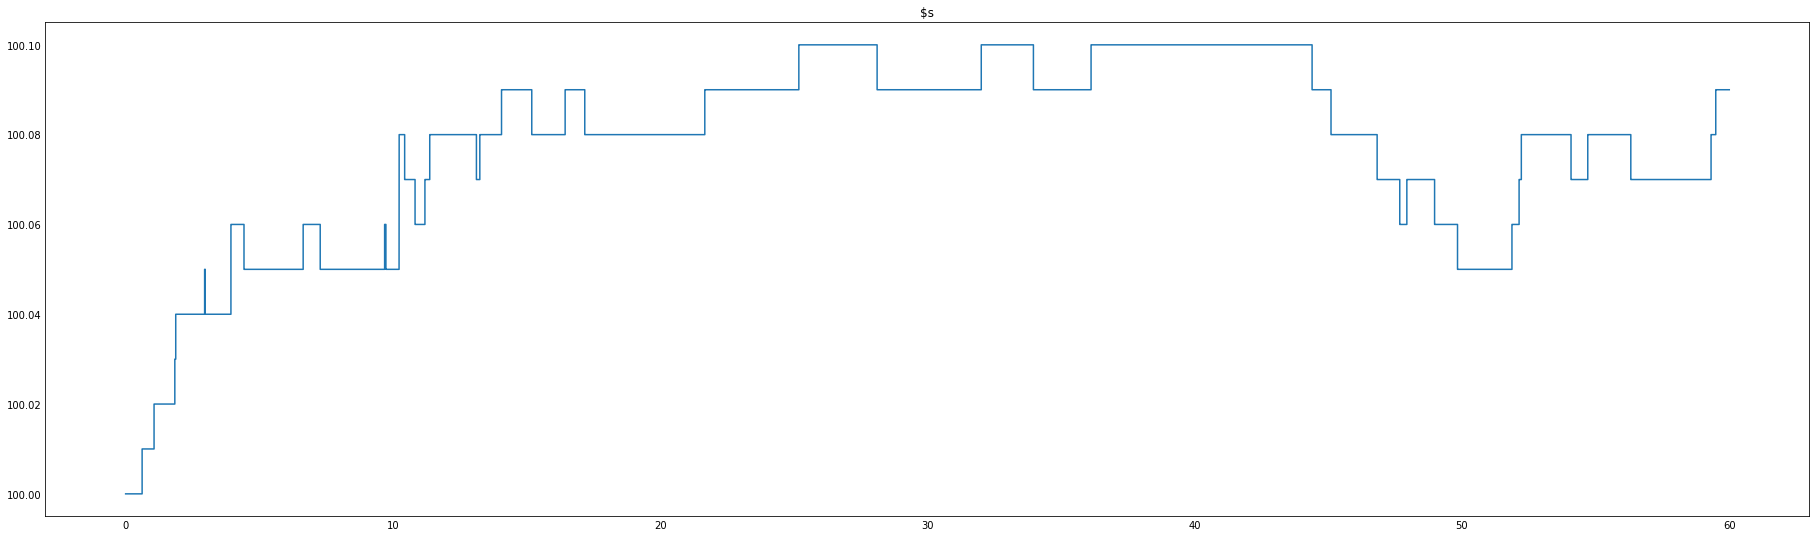

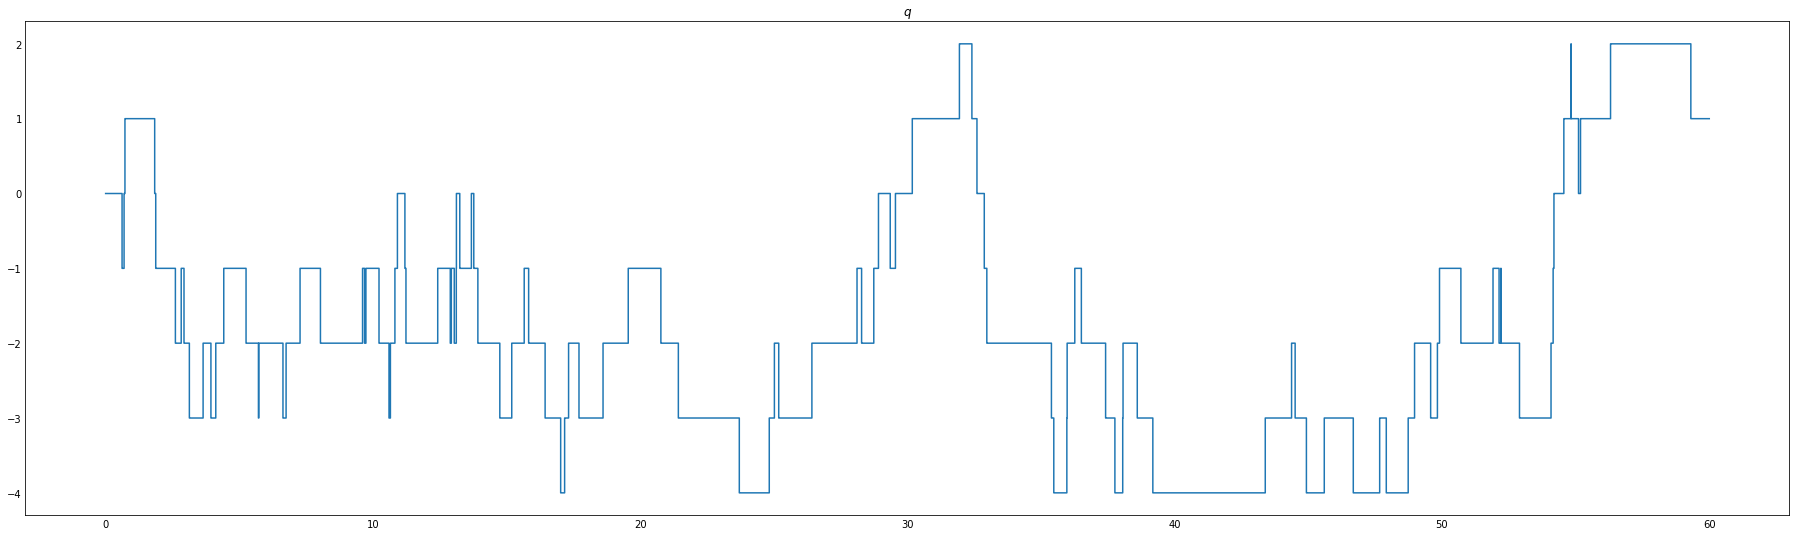

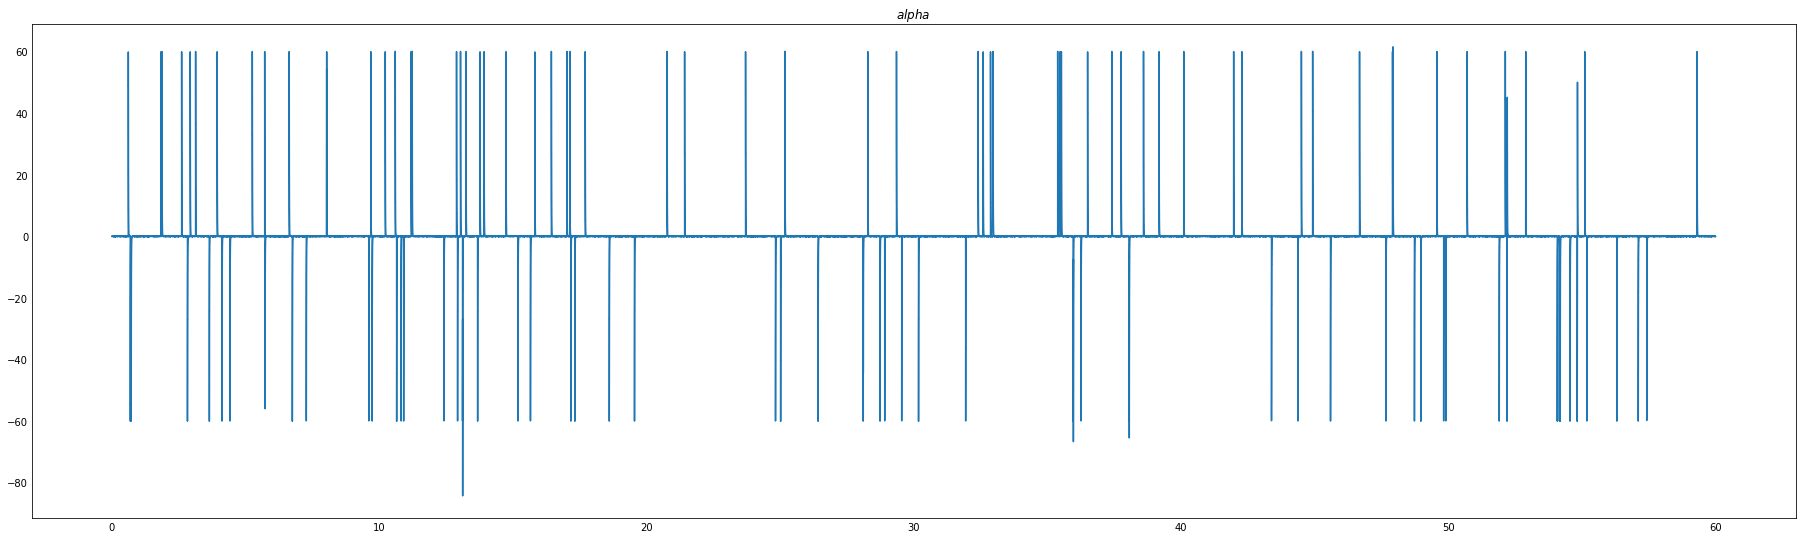

In [62]:
dt = (p.k * p.A / p.dalpha + p.lambda_plus + p.lambda_minus)**(-1)
m = int(p.T/dt)
plt_i = 1

plt.figure(figsize=(25,7))
plt.title('$pnl$')
plt.step(np.linspace(0,T,m),pnl[plt_i])

plt.figure(figsize=(25,7))
plt.title('$s')
plt.step(np.linspace(0,T,m),s[plt_i])

plt.figure(figsize=(25,7))
plt.title('$q$')
plt.step(np.linspace(0,T,m),q[plt_i])

plt.figure(figsize=(25,7))
plt.title('$alpha$')
plt.step(np.linspace(0,T,m),alpha[plt_i])


## Plots of positioning vs q

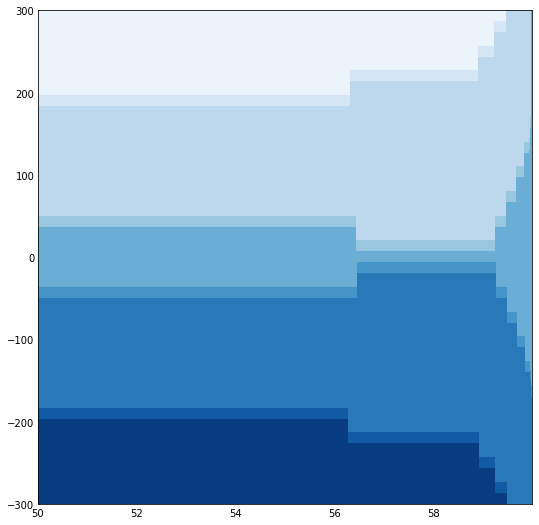

In [39]:
plt.style.use('_mpl-gallery-nogrid')

t_arange = np.arange(50,p.T,p.dt)
q_i = 4
# make data
X, Y = np.meshgrid(t_arange,np.arange(-p.A, p.A+1, p.dalpha))
Z_p = l_plus[-len(t_arange):,:,q_i].T
Z_m = l_minus[-len(t_arange):,:,q_i].T
Z_mo_p = mo_plus[-len(t_arange):,:,q_i].T
Z_mo_m = mo_minus[-len(t_arange):,:,q_i].T
Z = - Z_mo_p - Z_m + Z_p + Z_mo_m
levels = np.linspace(Z.min(), Z.max(), 10)

# plot
fig, ax = plt.subplots(figsize=(7,7))

ax.contourf(X, Y, Z, levels=levels)

plt.show()

## Price Path Simulation with parameters as in MM with alpha signals paper (Figure 3 a, b)